# Thick Sample Ptychography Forward Model Tutorial 2D

This tutorial demonstrates how to use `thick_ptycho` to set up and solve a 2D forward problem with multiple probes, both iteratively and as a full system.


The forward model solves the paraxial equation:

\begin{equation}
\frac{\partial u}{\partial z} = a \frac{\partial^2 u}{\partial x^2}  + C(x, z) u,
\end{equation}
where
\begin{equation}
a := \frac{1}{2ik} \qquad \text{and} \qquad C(x, z) := \frac{k}{2i} \left(n^2(x, z) - 1\right)
\end{equation}


**$n$ defines the refractive index of the volume. $k$ is the wave number.**

### 1. Import Libraries: Sample Space and Forward Model


In [1]:
# from thick_ptycho.sample_space.sample_space import SampleSpace
# from thick_ptycho.forward_model.solver import ForwardModel
from thick_ptycho.simulation.config import SimulationConfig, BoundaryType, ProbeType
from thick_ptycho.simulation.simulation_space import create_simulation_space
from thick_ptycho.simulation.ptycho_object import create_ptycho_object
from thick_ptycho.simulation.ptycho_probe import create_ptycho_probes
from thick_ptycho.forward_model import ForwardModelPWEIterative, ForwardModelPWEFull, ForwardModelMS
from matplotlib import pyplot as plt

import numpy as np

### 2. Set Simulation Parameters

Choose boundary conditions, probe type, and define the spatial domain and discretization.

2025-10-28 16:16:37,780 - INFO - === Scan Summary (Continuous) ===
2025-10-28 16:16:37,781 - INFO -   Sample space (x-range): 1.500e-04 m
2025-10-28 16:16:37,783 - INFO -   Sample space (z-range): 7.500e-05 m
2025-10-28 16:16:37,784 - INFO -   Probe diameter:         7.500e-06 m
2025-10-28 16:16:37,787 - INFO -   Number of scan points:  124
2025-10-28 16:16:37,788 - INFO -   Steps in z:             7
2025-10-28 16:16:37,790 - INFO -   Detector Pixels:        778
2025-10-28 16:16:37,792 - INFO -   Max Overlap:            6.921e-06 m
2025-10-28 16:16:37,794 - INFO -   Percentage Overlap:     478000000.00%

2025-10-28 16:16:37,801 - INFO - Saving refractive index field to ./results/ptycho_object_n_true


Theoretical scan dimensions:
  Total scan distance: 389
  Edge margin: 194
  Start index: 204
  Stop index: 573
  Final centre: 573
  Probe half-width: 10
  Last + half-width: 583
  Grid length: 778


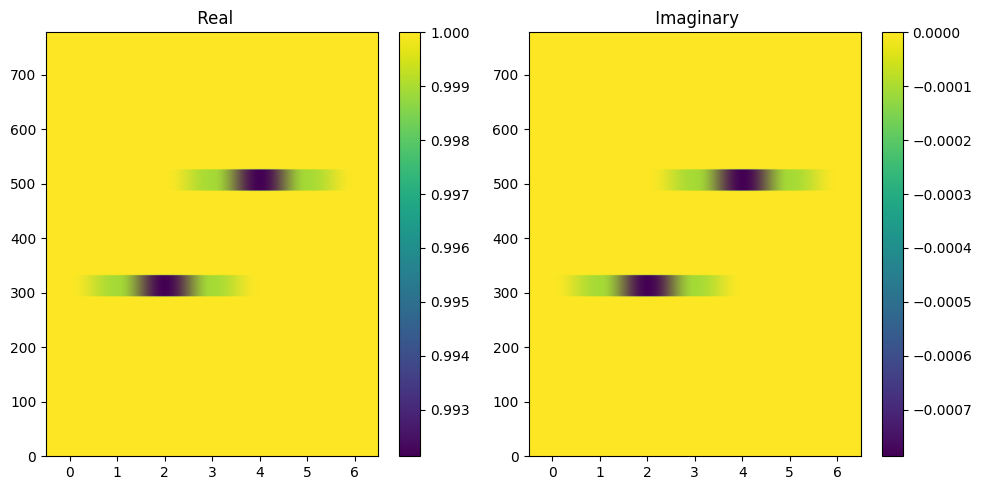

In [2]:
# --- Physical constants ---
from matplotlib.pyplot import imshow


wavelength = 0.635e-6        # meters (0.635 μm)
k0 = 2 * np.pi / wavelength  # wavenumber [1/m]

# --- Refractive index parameters ---
n_medium = 1.0               # background refractive index
delta = 0.01
beta = 0.001
refractive_index_perturbation = -delta - beta * 1j

# --- Probe configuration ---
probe_dimensions_discrete = [20]
probe_diameter_scale = 0.05
probe_focus = -1e-5                    # focal length [m]
scan_points = 124
step_size = 3                        # pixels between scans

pad_factor = 2.0  # Portion of extra space to add
# Define margin portion (half of extra space)
pad_margin = (pad_factor - 1) / 2.0

# --- Simulation spatial dimensions (in meters) ---
xlims = [0.0, 150e-6]   # meters (sample width)
zlims = [0.0, 75e-6]   # meters (sample thickness)
continuous_dimensions = (xlims, zlims)

# --- Discretization parameters ---
z_range = zlims[1] - zlims[0]
dz = wavelength * 16 # For multi-slice, keep dz larger to reduce number of slices
nz = int(z_range / dz)

# TODO: Make this padding apply to all dimensions
probe_width = probe_dimensions_discrete[0]
min_nx = (scan_points - 1) * step_size + probe_width
discrete_dimensions = (int(min_nx * pad_factor), nz)


# --- Enumerated configuration types ---
bc_type = BoundaryType.IMPEDANCE
probe_type = ProbeType.AIRY_DISK

# --- Create the SimulationConfig object ---
config_ms = SimulationConfig(
    continuous_dimensions=continuous_dimensions,
    discrete_dimensions=discrete_dimensions,
    probe_dimensions=probe_dimensions_discrete,
    scan_points=scan_points,
    step_size=step_size,
    bc_type=bc_type,
    probe_type=probe_type,
    wave_number=k0,
    probe_diameter_scale=probe_diameter_scale,
    probe_focus=probe_focus,
    tomographic_projection_90_degree=False,
    thin_sample=False,
    n_medium=n_medium,
    results_dir="./results",
    use_logging=True
)

# --- Create the simulation space ---
simulation_space_ms = create_simulation_space(config_ms)
simulation_space_ms.summarize()

# --- Create a Simultated Ptycho Object ---
ptycho_object_ms = create_ptycho_object(simulation_space_ms)


# TODO: Make objects move to the centre with padding or define them in min_nx
# Add 6 spheres of varying positions
gaussian_blur = 0.5
common_side_length = 0.05 # Portion of x-length
common_depth = 0.05  # Portion of z-length

# Add 6 spheres of varying positions
# ptycho_object.add_object('circle', refractive_index_perturbation, side_length=common_side_length,  
#                         centre=(0.5, 0.2), depth=common_depth, gaussian_blur=gaussian_blur)
ptycho_object_ms.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
                        centre=(0.4, 0.2), depth=common_depth, gaussian_blur=gaussian_blur)
ptycho_object_ms.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
                        centre=(0.65, 0.5), depth=common_depth, gaussian_blur=gaussian_blur)
# ptycho_object.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
#                         centre=(0.4, 0.7), depth=common_depth, gaussian_blur=gaussian_blur)
# ptycho_object.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
#                         centre=(0.55, 0.45), depth=common_depth, gaussian_blur=gaussian_blur)
# ptycho_object.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
#                         centre=(0.6, 0.3), depth=common_depth, gaussian_blur=gaussian_blur)
ptycho_object_ms.build_field()
ptycho_object_ms.save_n_true("ptycho_object_n_true")
simulation_space_ms.viewer.plot_two_panels(ptycho_object_ms.n_true,view="real_imag")


# --- Create a set of Simulated Ptycho Probes ---
ptycho_probes = create_ptycho_probes(simulation_space_ms)


2025-10-28 16:16:38,491 - INFO - === Scan Summary (Continuous) ===
2025-10-28 16:16:38,492 - INFO -   Sample space (x-range): 1.500e-04 m
2025-10-28 16:16:38,494 - INFO -   Sample space (z-range): 7.500e-05 m
2025-10-28 16:16:38,496 - INFO -   Probe diameter:         7.500e-06 m
2025-10-28 16:16:38,498 - INFO -   Number of scan points:  124
2025-10-28 16:16:38,499 - INFO -   Steps in z:             236
2025-10-28 16:16:38,500 - INFO -   Detector Pixels:        778
2025-10-28 16:16:38,503 - INFO -   Max Overlap:            6.921e-06 m
2025-10-28 16:16:38,506 - INFO -   Percentage Overlap:     478000000.00%



Theoretical scan dimensions:
  Total scan distance: 389
  Edge margin: 194
  Start index: 204
  Stop index: 573
  Final centre: 573
  Probe half-width: 10
  Last + half-width: 583
  Grid length: 778
Original refractive index shape: (778, 236)
Loaded refractive index shape: (778, 7)
Loaded refractive index new shape: (778, 236)


(<Figure size 1000x500 with 4 Axes>,
 array([<Axes: title={'center': ' Real'}>,
        <Axes: title={'center': ' Imaginary'}>], dtype=object))

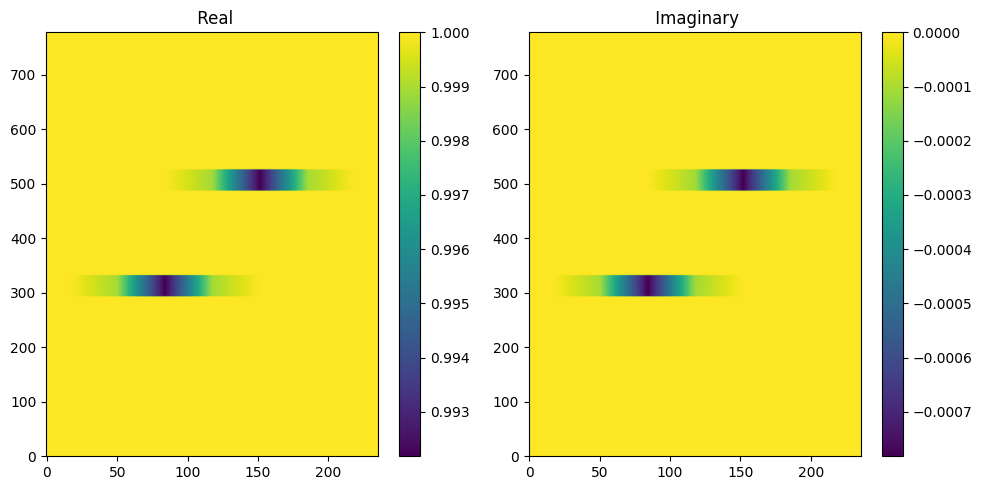

In [3]:
# --- Discretization parameters ---
z_range = zlims[1] - zlims[0]
dz = wavelength / 2
nz = int(z_range / dz)

# TODO: Make this padding apply to all dimensions
probe_width = probe_dimensions_discrete[0]
min_nx = (scan_points - 1) * step_size + probe_width
discrete_dimensions = (int(min_nx * pad_factor), nz)

# --- Create the SimulationConfig object ---
config_pwe = SimulationConfig(
    continuous_dimensions=continuous_dimensions,
    discrete_dimensions=discrete_dimensions,
    probe_dimensions=probe_dimensions_discrete,
    scan_points=scan_points,
    step_size=step_size,
    bc_type=bc_type,
    probe_type=probe_type,
    wave_number=k0,
    probe_diameter_scale=probe_diameter_scale,
    probe_focus=probe_focus,
    tomographic_projection_90_degree=False,
    thin_sample=False,
    n_medium=n_medium,
    results_dir="./results",
    use_logging=True
)

# --- Create the simulation space ---
simulation_space_pwe = create_simulation_space(config_pwe)
simulation_space_pwe.summarize()

# --- Create a Simultated Ptycho Object ---
ptycho_object_pwe = create_ptycho_object(simulation_space_pwe)
ptycho_object_pwe.load_and_resize_refractive_index("/home/dnz75396/thick_ptycho/notebooks/results/ptycho_object_n_true.npy")
simulation_space_pwe.viewer.plot_two_panels(ptycho_object_pwe.n_true,view="real_imag")


### 5. Solve the Forward Model


Solution is a complex propagated field, shape:

(num_projections, num_angles, num_probes, nx[,ny], nz).

In [4]:
# Solve Full Space Space, Iterative

# --- Create Forward Model ---
forward_model_pwe = ForwardModelPWEIterative(simulation_space_pwe,
                                ptycho_object_pwe,
                                ptycho_probes)

# Iterative solution
u_pwe = forward_model_pwe.solve()[0,0,...]

exit_waves = forward_model_pwe.get_exit_waves(u_pwe)
intensities = forward_model_pwe.get_farfield_intensities(exit_waves=exit_waves, 
                                                           poisson_noise=True)


In [5]:
# simulation_space_pwe.viewer.plot_two_panels(exit_waves,
#                                         view="phase_amp", 
#                                         title="Exit Waves PWE",
#                                         xlabel="z (m)",
#                                         ylabel="x (m)")

# simulation_space_pwe.viewer.plot_single_panel(intensities,
#                                         title="Far-field Intensities PWE",
#                                         xlabel="z (m)",
#                                         ylabel="x (m)")

# # Select Centre Probe
# centre_probe_pwe = u_pwe[simulation_space_pwe.num_probes//2, ...]
# simulation_space_pwe.viewer.plot_two_panels(centre_probe_pwe,
#                                         view="phase_amp", 
#                                         title="Wavefield Solution PWE",
#                                         xlabel="z (m)",
#                                         ylabel="x (m)")

# plt.plot(simulation_space_pwe.x, centre_probe_pwe[:, nz//2])
# plt.show()

# plt.figure(figsize=(8,4))
# probe_indices = np.linspace(0, simulation_space_pwe.num_probes-1, min(4, simulation_space_pwe.num_probes), dtype=int)
# for p in probe_indices:
#     plt.plot(simulation_space_pwe.x, np.abs(u_pwe[p,:,0]), label=f'probe {p}')
# plt.title("Probe amplitudes (subset)")
# plt.xlabel("x"); plt.legend(); plt.tight_layout(); plt.show()

# for p in probe_indices:
#     plt.plot(simulation_space_pwe.x, np.abs(u_pwe[p,:,-1]), label=f'probe {p}')
# plt.title("Exitwave amplitudes (subset)")
# plt.xlabel("x"); plt.legend(); plt.tight_layout(); plt.show()


In [6]:
# # Solve Full Space Space, Multislice

# forward_model_ms = ForwardModelMS(simulation_space_ms,
#                                 ptycho_object_ms,
#                                 ptycho_probes)

# # Iterative solution
# u_ms = forward_model_ms.solve()[0,0,...]

# exit_waves_ms =forward_model_ms.get_exit_waves(u_ms)
# intensities_ms = forward_model_ms.get_farfield_intensities(exit_waves=exit_waves_ms, 
#                                                                poisson_noise=True)

In [7]:
# simulation_space_ms.viewer.plot_two_panels(exit_waves_ms,
#                                         view="phase_amp", 
#                                         title="Exit Waves Multislice",
#                                         xlabel="z (m)",
#                                         ylabel="x (m)")

# simulation_space_ms.viewer.plot_single_panel(intensities_ms,
#                                         title="Far-field Intensities Multislice",
#                                         xlabel="z (m)",
#                                         ylabel="x (m)")

# # Select Centre Probe
# centre_probe_ms = u_ms[simulation_space_ms.num_probes//2, ...]
# simulation_space_ms.viewer.plot_two_panels(centre_probe_ms,
#                                         view="phase_amp", 
#                                         title="Wavefield Solution Multislice",
#                                         xlabel="z (m)",
#                                         ylabel="x (m)")

# plt.figure(figsize=(8,4))
# for p in probe_indices:
#     plt.plot(simulation_space_ms.x, np.abs(u_ms[p,:,0]), label=f'probe {p}')
# plt.title("Probe amplitudes (subset)")
# plt.xlabel("x"); plt.legend(); plt.tight_layout(); plt.show()

# for p in probe_indices:
#     plt.plot(simulation_space_ms.x, np.abs(u_ms[p,:,-1]), label=f'probe {p}')
# plt.title("Exitwave amplitudes (subset)")
# plt.xlabel("x"); plt.legend(); plt.tight_layout(); plt.show()

### 6. Solve in Reverse
The exit wave of the forward solution can be set as the initial condition for
the system to be solved in reverse. 

In [8]:
# from thick_ptycho.reconstruction.ms_reconstructor import ReconstructorMS

# recon_ms = ReconstructorMS(simulation_space_ms, intensities_ms,verbose=True)


# n_est, loss_history = recon_ms.reconstruct(max_iters=5,alpha_obj=1e-4)
# simulation_space_ms.viewer.plot_two_panels(n_est,view="real_imag")


### 7. Visualisations

Module to help view sample space and solutions.

In [11]:
from thick_ptycho.reconstruction.pwe_reconstructor import ReconstructorPWE

recon_pwe = ReconstructorPWE(simulation_space_pwe, intensities,verbose=True)
recon_pwe.reconstruct(max_iters=5)

Initializing Least Squares Solver...


ValueError: cannot reshape array of size 778 into shape (235,778)

In [ ]:
# # Visualise the Sample Space
# visualisation.plot(solution=sample_space.n_true,title="Sample Space")

In [ ]:
# Plot Solution for Full Sample Solves
plot_phase = True

visualisation.plot(solution=solution_iterative_full[0], plot_phase=plot_phase,probe_index=0)
visualisation.plot(solution=solution_iterative_full[0], plot_phase=plot_phase,probe_index=int(scan_points/2))
visualisation.plot(solution=solution_iterative_full[0], plot_phase=plot_phase,probe_index=-1)
# visualisation.plot(solution=solution_iterative_full[1], plot_phase=plot_phase,probe_index=-1)
# visualisation.plot(solution=solution_iterative_full[2], plot_phase=plot_phase,probe_index=-1)

NameError: name 'visualisation' is not defined

### Compare with Homogeneous Sample

In [ ]:
# sample_space = SampleSpace(
#     continuous_dimensions, # sample space dimensions in nanometers (x, z) or (x, y, z)
#     discrete_dimensions,   # sample space dimensions in pixels (nx, nz) or (nx, ny, nz)
#     probe_dimensions,        # shape of the detector in pixels - subset of (nx) or (nx, ny)
#     scan_points,           # number of ptychography scan points or sqrt(scan_points) for square scan
#     step_size,
#     bc_type,               # boundary condition type (impedance, dirichlet, neumann)
#     probe_type,
#     k0,            # wavenumber in 1/nm
#     n_medium=nb,
# )
# sample_space.generate_sample_space()

# # Solve Full Space Space, Iterative
# forward_model_iterative_full = ForwardModel(sample_space,
#                              full_system_solver=False,
#                              thin_sample=False,
#                              probe_angles=probe_angle)


# # Iterative solution
# print("Solving iteratively for full sample...")
# solution_iterative_full_homogeneous = forward_model_iterative_full.solve(verbose=True)

In [ ]:
# difference = solution_iterative_full_homogeneous - solution_iterative_full
# # Plot Solution for Full Sample Solves
# plot_phase = False

# visualisation.plot(solution=solution_iterative_full[0], plot_phase=plot_phase)
# visualisation.plot(solution=solution_iterative_full[1], plot_phase=plot_phase)
# visualisation.plot(solution=solution_iterative_full[2], plot_phase=plot_phase)

In [ ]:
# ---------- Phase & Amplitude (and differences) ----------
fig = plt.figure(figsize=(8, 4))
plt.imshow(data, cmap='viridis', origin='lower')
plt.colorbar(label='Intensity')
plt.title(f'Exit Wave Squared FFT Intensity {title_prefix}'.strip())
plt.xlabel('x'); plt.ylabel('Image #'); plt.tight_layout()
fig.savefig(os.path.join(self._results_dir, f'true_fft_intensity{ "_rot" if title_prefix else ""}.png'),
            bbox_inches="tight")
plt.close(fig)

fig = plt.figure(figsize=(8, 4))
plt.imshow(diff_data, cmap='viridis', origin='lower')
plt.colorbar(label='Intensity')
plt.title(f'Differences in Exit Waves {title_prefix}:\nFar Field Intensity'.strip())
plt.xlabel('x'); plt.ylabel('Image #'); plt.tight_layout()
fig.savefig(os.path.join(self._results_dir, f'true_fft_intensity_diff{ "_rot" if title_prefix else ""}.png'),
            bbox_inches="tight")
plt.close(fig)

visualisation.plot_single(
        exit_waves, view="phase_amp", time="final",
        filename=f"exit_phase_amp{ '_rot' if title_prefix else ''}.png",
        title_left=f"Exit Wave Phase {title_prefix}".strip(),
        title_right=f"Exit Wave Amplitude {title_prefix}".strip(),
        xlabel_left="x",  ylabel_left="Image #",
        xlabel_right="x", ylabel_right="Image #",
    )

visualisation.plot_single(
        diff_exit_waves, view="phase_amp", time="final",
        filename=f"exit_phase_amp_diff{ '_rot' if title_prefix else ''}.png",
        title_left=f"Phase Differences in Exit Waves {title_prefix}:\nHomogeneous vs. Inhomogeneous Media".strip(),
        title_right=f"Amplitude Differences in Exit Waves {title_prefix}:\nHomogeneous vs. Inhomogeneous Media".strip(),
        xlabel_left="x",  ylabel_left="Image #",
        xlabel_right="x", ylabel_right="Image #",
    )